Ejecuta la celda 1 para generar los datos de entrenamiento
con 20 muestras de la clase 1 y 15 para la clase 2, deja el
parámetro load_data=False

In [4]:
!pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 68.4 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00


X.shape  (35, 2)
y.shape  (35,)


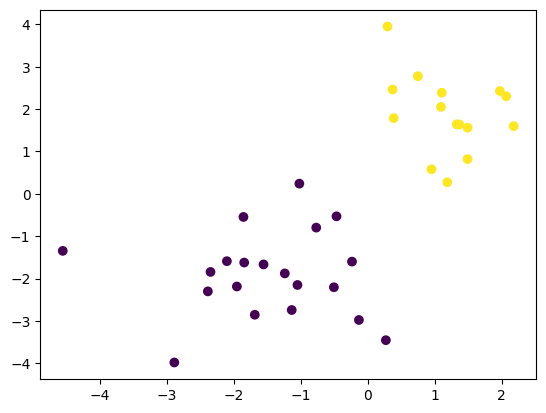

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

load_data = False
X_data, y_label = [], []

if load_data:  # Cargar datos no separables
    with open("datos_perceptron.csv", newline="") as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        header = next(reader, None)
        for i, row in enumerate(reader):
            X_data.append([float(row[0]), float(row[1])])
            y_label.append(-1 if int(row[2]) == 0 else +1)  # if y=0 -> -1; else +1
        X_data = np.array(X_data)
        y_label= np.array(y_label)

else:  # Generar datos separables
    muestras_c1 = 20
    muestras_c2 = 15
    np.random.seed(0)  # Semilla para replicar los resultados
    X_data = np.r_[np.random.randn(muestras_c1, 2) - [2, 2],
                   np.random.randn(muestras_c2, 2) + [2, 2]]
    y_label = np.array([-1] * muestras_c1 + [1] * muestras_c2)


print("X.shape ", X_data.shape)
print("y.shape ", y_label.shape)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(X_data[:,0], X_data[:,1], c=y_label)
plt.show()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

Completa la celda 2 para implementar una SVM lineal con margen suave.

Hint: Identifica el proceso para aplicar cvxpy en fuentes oficiales. Usa las funciones: Minimize, norm2, Problem, solve de cvxpy

In [40]:
import cvxpy

class Linear_SVC(object):
    def __init__(self, C=1.0):
        if C <= 0:
            msj = "El valor de penalización C " + str(C) + " debe ser mayor a 0"
            raise ValueError(str(msj))
        self.C = C

    def verify_class(self, Y):
        classes = []
        classes.append(Y[0])
        for c in Y:
            if c not in classes:
                classes.append(c)
        return classes

    def div_classes(self, matX, Y, classes):
        classA, classB = [], []
        for i, dat in enumerate(matX):
            if Y[i] == -1:  # classes[0]
                classB.append(dat)
            else:  # +1 classes[1]
                classA.append(dat)
        return classA, classB

    def fit(self, X, Y, margin='soft'):
        classes = self.verify_class(Y)
        print('Clases: ', classes)

        x1, x2 = self.div_classes(X, Y, classes)
        x1 = np.asmatrix(x1)   # Datos clase -1
        x2 = np.asmatrix(x2)   # Datos clase +1
        N = x1.shape[0]
        M = x2.shape[0]
        features = X.shape[1]
        print('features.shape: ', features)

        """Variable() es un escalar restringido a ser no negativo"""
        w = cvxpy.Variable(features, "1")  # Variable de 2 elementos(Ws)
        w0 = cvxpy.Variable(1)  # Variable de 1 elemento (b)
        u = cvxpy.Variable(N, "1")  # Variable del número de muestras de la clase -1
        v = cvxpy.Variable(M, "1")  # Variable del número de muestras de la clase +1
        if margin=="soft":
            # Margen suave
            objective = cvxpy.Minimize(cvxpy.norm2(w) + self.C * (np.ones((1, N))@u + np.ones((1, M))@v))
            constraint = [x1@w + w0 >= (1 - u), x2@w + w0 <= -(1 - v), u >= 0, v >= 0]

        # Aplicar solución
        prob = cvxpy.Problem(objective, constraint)
        prob.solve()
        # Regresar resultados
        return np.asarray(w.value), np.asarray(w0.value)


Completa la celda 3 para cargar la función plot_svm_boundary

In [33]:
def plot_svm_boundary(w, bias, X_data, y_label, xlim, ylim):
    pendiente = -w[0]/(w[1] + 0.0001)
    cruce = -bias/(w[1] + 0.0001)
    xx = np.linspace(xlim[0], xlim[1])
    yy = pendiente * xx  + cruce  # Y = mX + b

    margen = 1 / np.sqrt(np.sum(X_data ** 2))  # norma
    yy_sup = yy + np.sqrt(1 + pendiente ** 2) * margen  # frontera -1
    yy_inf = yy - np.sqrt(1 + pendiente ** 2) * margen  # frontera +1

    plt.figure()
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y_label)
    plt.plot(xx, yy, 'b-')
    plt.plot(xx, yy_inf, 'r--')
    plt.plot(xx, yy_sup, 'r--')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

Celda 4: Crea una instancia de la clase Linear_SVC implementada y aplique el ajuste a los datos generados, imprime la frontera llamando la función de la celda 3

Clases:  [-1, 1]
features.shape:  2
W: [0.90244164 0.6480461 ] b: [-0.23448053]


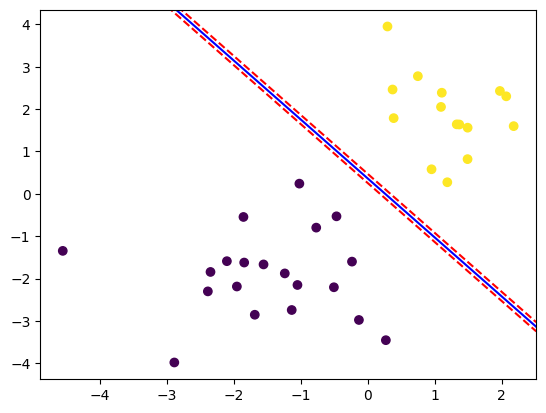

In [41]:
clf = Linear_SVC()
w, b = clf.fit(X_data, y_label, margin="soft")
print("W:",w, "b:", b)

# Dibujar frontera
plot_svm_boundary(w, b, X_data, y_label, xlim, ylim)

Celda 5: Utiliza las svm de sklearn y compara los resultados con la celda 4

W: [0.90243862 0.64806347] b: [-0.23448774]


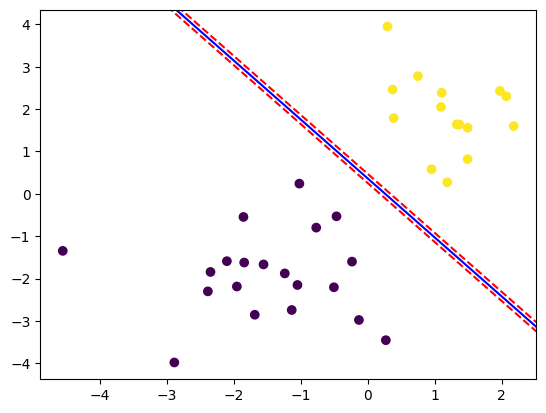

In [37]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, max_iter=100000000, loss="hinge", C=1.0)
clf.fit(X_data, y_label)
w = clf.coef_.squeeze()
b = clf.intercept_
print("W:", w, "b:", b)

# Dibujar frontera
plot_svm_boundary(w, b, X_data, y_label, xlim, ylim)